In [1]:
from rmgpy.cantherm import CanTherm, KineticsJob, StatMechJob
from rmgpy.cantherm import *
from autotst.reaction import *

In [2]:
reactants = [Molecule(SMILES="CC=C(C)C"), Molecule(SMILES="[O]O")]
products = [Molecule(SMILES="[CH2]C=C(C)C"), Molecule(SMILES="OO")]
rmg_reaction = Reaction(reactants=reactants, products=products)

rxn = AutoTST_Reaction(reaction_family="H_Abstraction", rmg_reaction=rmg_reaction)


thermo.py:839 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:856 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/transport/groups...
database.py:167 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-Py/../RMG-database/input/kinetics/families
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/

## Writing the overall CanTherm file

In [3]:
def write_cantherm_ts(rxn):
    top = ["#!/usr/bin/env python", "# -*- coding: utf-8 -*-", "", 'modelChemistry = "M06-2X/cc-pVTZ"', "frequencyScaleFactor = 0.982", "useHinderedRotors = False", "useBondCorrections = False", ""]

    scratch ="."
    for react in rxn.reactant_mols:
        line = "species('{0}', '{1}')".format(react.smiles, os.path.join(scratch, react.smiles +".py"))
        top.append(line)

    for prod in rxn.product_mols:
        line = "species('{0}', '{1}')".format(prod.smiles, os.path.join(scratch, prod.smiles +".py"))
        top.append(line)

    line = "transitionState('TS', '{0}')".format(os.path.join(scratch, rxn.label +".py"))
    top.append(line)


    line = ["",
    "reaction(",
    "    label = '{0}',".format(rxn.label),
    "    reactants = ['{0}', '{1}'],".format(rxn.reactant_mols[0].smiles, rxn.reactant_mols[1].smiles),
    "    products = ['{0}', '{1}'],".format(rxn.product_mols[0].smiles, rxn.product_mols[1].smiles),
    "    transitionState = 'TS',",
    "    tunneling = 'Eckart',",
    ")",
    "",
    "statmech('TS')",
    "kinetics('{0}')".format(rxn.label)]
    top += line


    input_string = ""

    for t in top:
        input_string += t +"\n"

    with open(rxn.label +".cantherm.py", "w") as f:
        f.write(input_string)

In [4]:
def write_statmech_ts(rxn):
    output = ['#!/usr/bin/env python', '# -*- coding: utf-8 -*-', '', 'atoms = {']


    atom_dict = get_atoms(rxn)

    for atom, count in atom_dict.iteritems():
        output.append("    '{0}': {1},".format(atom, count))
    output = output + ['}', '']


    bond_dict = get_bonds(rxn)
    if bond_dict != {}:
        output.append('bonds = {')
        for bond_type, num in bond_dict.iteritems():
            output.append("    '{0}': {1},".format(bond_type, num))
            
        output.append("}")
    else:
        output.append('bonds = {}')



    output += ["","linear = False","","externalSymmetry = 1", "", "spinMultiplicity = {}".format(rxn.ts.rmg_ts.multiplicity), "", "opticalIsomers = 1", ""]

    output += ["energy = {","    'M06-2X/cc-pVTZ': GaussianLog('{}_overall.log'),".format(rxn.label),"}",""]

    output += ["geometry = GaussianLog('{}_overall.log')".format(rxn.label), ""]

    output += ["frequencies = GaussianLog('{}_overall.log')".format(rxn.label), ""]

    output += ["rotors = []", ""]

    input_string = ""

    for t in output:
        input_string += t +"\n"
    print input_string

    with open(os.path.join(rxn.label +".py"), "w") as f:
        f.write(input_string)

In [5]:
def write_cantherm_for_reacts_and_prods(mol):

    output = ['#!/usr/bin/env python', '# -*- coding: utf-8 -*-', '', 'atoms = {']
            
    atom_dict = get_atoms(mol)

    for atom, count in atom_dict.iteritems():
        output.append("    '{0}': {1},".format(atom, count))
    output = output + ['}', '']

    bond_dict = get_bonds(mol)
    if bond_dict != {}:
        output.append('bonds = {')
        for bond_type, num in bond_dict.iteritems():
            output.append("    '{0}': {1},".format(bond_type, num))
        output.append("}")
    else:
        output.append('bonds = {}')



    output += ["","linear = False","","externalSymmetry = 1", "", "spinMultiplicity = {}".format(mol.rmg_molecule.multiplicity), "", "opticalIsomers = 1", ""]

    output += ["energy = {","    'M06-2X/cc-pVTZ': GaussianLog('{}.log'),".format(mol.smiles),"}",""]

    output += ["geometry = GaussianLog('{}.log')".format(mol.smiles), ""]

    output += ["frequencies = GaussianLog('{}.log')".format(mol.smiles), ""]

    output += ["rotors = []"]

    input_string = ""

    for t in output:
        input_string += t +"\n"

    with open(os.path.join(mol.smiles+".py"), "w") as f:
        f.write(input_string)
        


In [6]:
def get_bonds(mol):
    bondList = []
    if isinstance(mol, AutoTST_Molecule):
        rmg_mol = mol.rmg_molecule
    elif isinstance(mol, AutoTST_Reaction):
        rmg_mol = mol.ts.rmg_ts
    elif isinstance(mol, AutoTST_TS):
        rmg_mol = mol.rmg_ts
    for atom in rmg_mol.atoms:
        for bond in atom.bonds.values():
            bondList.append(bond)
    bonds = list(set(bondList))
    bondDict = {}
    for bond in bonds:
        if bond.isSingle():
            if bond.atom1.symbol=='C' and bond.atom2.symbol=='C':
                bondType = 'C-C'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='H'):
                bondType = 'H-H'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='H') or (bond.atom1.symbol=='H' and bond.atom2.symbol=='C'):
                bondType = 'C-H'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='O'):
                bondType = 'O-O'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='O') or (bond.atom1.symbol=='O' and bond.atom2.symbol=='C'):
                bondType = 'C-O'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='O') or (bond.atom1.symbol=='O' and bond.atom2.symbol=='H'):
                bondType = 'O-H'
            elif bond.atom1.symbol=='N' and bond.atom2.symbol=='N':
                bondType = 'N-N'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='C'):
                bondType = 'N-C'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='O'):
                bondType = 'N-O'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='H'):
                bondType = 'N-H'
            elif bond.atom1.symbol=='S' and bond.atom2.symbol=='S':
                bondType = 'S-S'
            elif (bond.atom1.symbol=='H' and bond.atom2.symbol=='S') or (bond.atom1.symbol=='S' and bond.atom2.symbol=='H'):
                bondType = 'S-H'
        elif bond.isDouble:
            if bond.atom1.symbol=='C' and bond.atom2.symbol=='C':
                bondType = 'C=C'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='O'):
                bondType = 'O=O'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='O') or (bond.atom1.symbol=='O' and bond.atom2.symbol=='C'):
                bondType = 'C=O'
            elif bond.atom1.symbol=='N' and bond.atom2.symbol=='N':
                bondType = 'N=N'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='C'):
                bondType = 'N=C'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='O'):
                bondType = 'N=O'
            elif (bond.atom1.symbol=='O' and bond.atom2.symbol=='S') or (bond.atom1.symbol=='S' and bond.atom2.symbol=='O'):
                bondType = 'S=O'
        elif bond.isTriple:
            if bond.atom1.symbol=='C' and bond.atom2.symbol=='C':
                bondType = 'C#C'
            elif bond.atom1.symbol=='N' and bond.atom2.symbol=='N':
                bondType = 'N#N'
            elif (bond.atom1.symbol=='C' and bond.atom2.symbol=='N') or (bond.atom1.symbol=='N' and bond.atom2.symbol=='C'):
                bondType = 'N#C'
        try:
            bondDict[bondType] += 1
        except KeyError:
            bondDict[bondType] = 1

    return bondDict

In [7]:
def get_atoms(mol):
    atom_dict={}
    if isinstance(mol, AutoTST_Molecule):
        rmg_mol = mol.rmg_molecule
    elif isinstance(mol, AutoTST_Reaction):
        rmg_mol = mol.ts.rmg_ts
    elif isinstance(mol, AutoTST_TS):
        rmg_mol = mol.rmg_ts
    for atom in rmg_mol.atoms:
        if atom.isCarbon():
            atom_type = "C"
        if atom.isHydrogen():
            atom_type = "H"
        if atom.isOxygen():
            atom_type = "O"

        try:
            atom_dict[atom_type] += 1
        except KeyError:
            atom_dict[atom_type] = 1
            
    return atom_dict

In [8]:
for mol in rxn.reactant_mols:
    write_cantherm_for_reacts_and_prods(mol)
    
for mol in rxn.product_mols:
    write_cantherm_for_reacts_and_prods(mol)
    
write_statmech_ts(rxn)

write_cantherm_ts(rxn)

#!/usr/bin/env python
# -*- coding: utf-8 -*-

atoms = {
    'H': 11,
    'C': 5,
    'O': 2,
}

bonds = {
    'O-O': 1,
    'C=C': 1,
    'O-H': 1,
    'C-C': 3,
    'C-H': 10,
}

linear = False

externalSymmetry = 1

spinMultiplicity = 2

opticalIsomers = 1

energy = {
    'M06-2X/cc-pVTZ': GaussianLog('CC=C(C)C+[O]O_[CH2]C=C(C)C+OO_overall.log'),
}

geometry = GaussianLog('CC=C(C)C+[O]O_[CH2]C=C(C)C+OO_overall.log')

frequencies = GaussianLog('CC=C(C)C+[O]O_[CH2]C=C(C)C+OO_overall.log')

rotors = []




In [9]:
cantherm_job = CanTherm()
cantherm_job.inputFile = rxn.label + ".cantherm.py"
cantherm_job.plot = False
cantherm_job.outputDirectory = "."

cantherm_job.execute()

CanTherm execution initiated at Fri May  4 15:49:06 2018

###############################################################
#                                                             #
#                          CanTherm                           #
#                                                             #
#   Version: 2.1.0                                            #
#   Authors: RMG Developers (rmg_dev@mit.edu)                 #
#   P.I.s:   William H. Green (whgreen@mit.edu)               #
#            Richard H. West (r.west@neu.edu)                 #
#   Website: http://reactionmechanismgenerator.github.io/     #
#                                                             #
###############################################################

Loading species CC=C(C)C...
Loading species [O]O...
Loading species [CH2]C=C(C)C...
Loading species OO...
Loading transition state TS...
Loading reaction CC=C(C)C+[O]O_[CH2]C=C(C)C+OO...


Loading statistical mechanics parameters for CC=

/Users/nathan/Code/RMG-Py/rmgpy/cantherm/kinetics.py:166: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.reaction.kinetics = Arrhenius().fitToData(Tlist, klist, kunits=self.kunits)



CanTherm execution terminated at Fri May  4 15:49:08 2018


/Users/nathan/Code/RMG-Py/rmgpy/cantherm/kinetics.py:228: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kinetics0rev = Arrhenius().fitToData(Tlist, numpy.array(k0revs), kunits=self.krunits)
/Users/nathan/Code/RMG-Py/rmgpy/cantherm/kinetics.py:229: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kineticsrev = Arrhenius().fitToData(Tlist, numpy.array(krevs), kunits=self.krunits)


In [10]:
for job in cantherm_job.jobList:
    if isinstance(job, KineticsJob):
        break

In [11]:
for reactant in rxn.reactant_mols:
    for r in job.reaction.reactants: 
        if reactant.smiles == r.label:
            r.molecule = [reactant.rmg_molecule]
            
for product in rxn.product_mols:
    for p in job.reaction.products: 
        if product.smiles == p.label:
            p.molecule = [product.rmg_molecule]

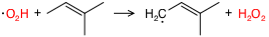

In [12]:
job.reaction

In [13]:
print "{0!r}".format(job.reaction)

Reaction(label='CC=C(C)C+[O]O_[CH2]C=C(C)C+OO', reactants=[Species(label="[O]O", conformer=Conformer(E0=(1936.47,'kJ/mol'), modes=[IdealGasTranslation(mass=(32.9977,'amu')), NonlinearRotor(inertia=([0.775043,14.5598,15.3349],'amu*angstrom^2'), symmetry=1), HarmonicOscillator(frequencies=([1228.4,1593.69,3942.52],'cm^-1'))], spinMultiplicity=2), molecule=[Molecule(SMILES="[O]O")]), Species(label="CC=C(C)C", conformer=Conformer(E0=(3546.66,'kJ/mol'), modes=[IdealGasTranslation(mass=(70.0782,'amu')), NonlinearRotor(inertia=([62.5929,143.621,196.994],'amu*angstrom^2'), symmetry=1), HarmonicOscillator(frequencies=([117.231,134.704,189.224,278.553,313.164,403.088,485.653,549.797,803.349,902.596,1017.95,1032.88,1098.3,1139.51,1155.72,1194.66,1205.24,1318.16,1476.87,1538.13,1541.56,1551.02,1589.96,1601.1,1601.23,1609.84,1615.09,1615.76,1881.78,3127.87,3135.15,3138.61,3169.45,3175.38,3176.31,3218.89,3231.29,3253.11,3261.32],'cm^-1'))]), molecule=[Molecule(SMILES="CC=C(C)C")])], products=[Specie

In [14]:
from autotst.calculators.cantherm import *

In [15]:
calc = AutoTST_CanTherm(rxn)

In [16]:
calc.write_files()

In [17]:
calc.run()

CanTherm execution initiated at Fri May  4 15:49:09 2018

###############################################################
#                                                             #
#                          CanTherm                           #
#                                                             #
#   Version: 2.1.0                                            #
#   Authors: RMG Developers (rmg_dev@mit.edu)                 #
#   P.I.s:   William H. Green (whgreen@mit.edu)               #
#            Richard H. West (r.west@neu.edu)                 #
#   Website: http://reactionmechanismgenerator.github.io/     #
#                                                             #
###############################################################

Loading species CC=C(C)C...
Loading species [O]O...
Loading species [CH2]C=C(C)C...
Loading species OO...
Loading transition state TS...
Loading reaction CC=C(C)C+[O]O_[CH2]C=C(C)C+OO...


Loading statistical mechanics parameters for CC=

In [18]:
calc.set_reactants_and_products()

<AutoTST Reaction "CC=C(C)C+[O]O_[CH2]C=C(C)C+OO">

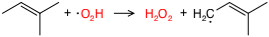

In [19]:
calc.kinetics_job.reaction

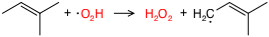

In [20]:
calc.reaction.rmg_reaction